In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import datasets
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
import requests
from tqdm import tqdm
import pickle 
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Load Dataset

### Load Reference Datasets

In [2]:
%%time
sea_vqa_images_filt, sea_vqa_images_embed, sea_vqa_caption, sea_vqa_culture = pickle.load(open('sea_vqa.pkl', 'rb'))
cvqa_images_filt, cvqa_images_embed, cvqa_caption, cvqa_culture = pickle.load(open('cvqa.pkl', 'rb'))

ref_images_filt = sea_vqa_images_filt + cvqa_images_filt
ref_images_embed = sea_vqa_images_embed + cvqa_images_embed
ref_vqa_caption = sea_vqa_caption + cvqa_caption
ref_vqa_culture = sea_vqa_culture + cvqa_culture

CPU times: user 10 s, sys: 30.3 s, total: 40.3 s
Wall time: 40.3 s


### Perform Clustering Analysis

In [3]:
np_ref_embed = np.stack(ref_images_embed, axis=0)
dist_mat = np.dot(np_ref_embed, np_ref_embed.T) /(np.linalg.norm(np_ref_embed) * np.linalg.norm(np_ref_embed.T))

/home/samuel/anaconda2/envs/env_instruct_align/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/samuel/anaconda2/envs/env_instruct_align/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/samuel/anaconda2/envs/env_instruct_align/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/samuel/anaconda2/envs/env_instruct_align/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

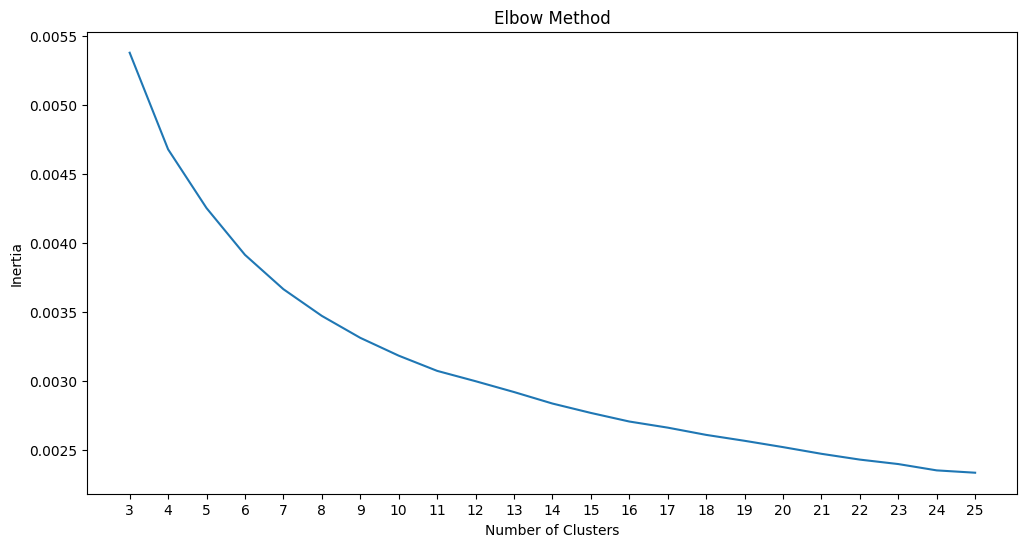

In [4]:
# Perform k-means clustering
# Run elbow method to determine the best number of clusters
inertia = []
range_clusters = range(3, 26, 1)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dist_mat)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(range_clusters, inertia)
plt.xticks(range_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

/home/samuel/anaconda2/envs/env_instruct_align/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


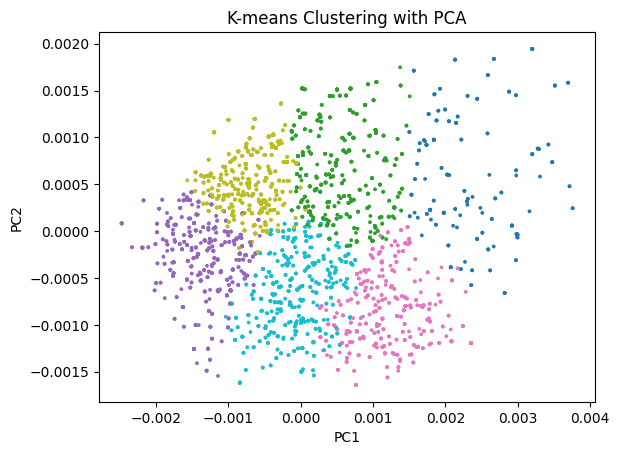

In [26]:
# Choose the best number of clusters based on the elbow curve
best_k = 6  # Replace with the appropriate number of clusters based on the elbow curve

# Perform k-means clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(dist_mat)
cluster_labels = kmeans.predict(dist_mat)

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(dist_mat)

# Visualize scatter plot colored by the cluster
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, s=3, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering with PCA')
plt.show()

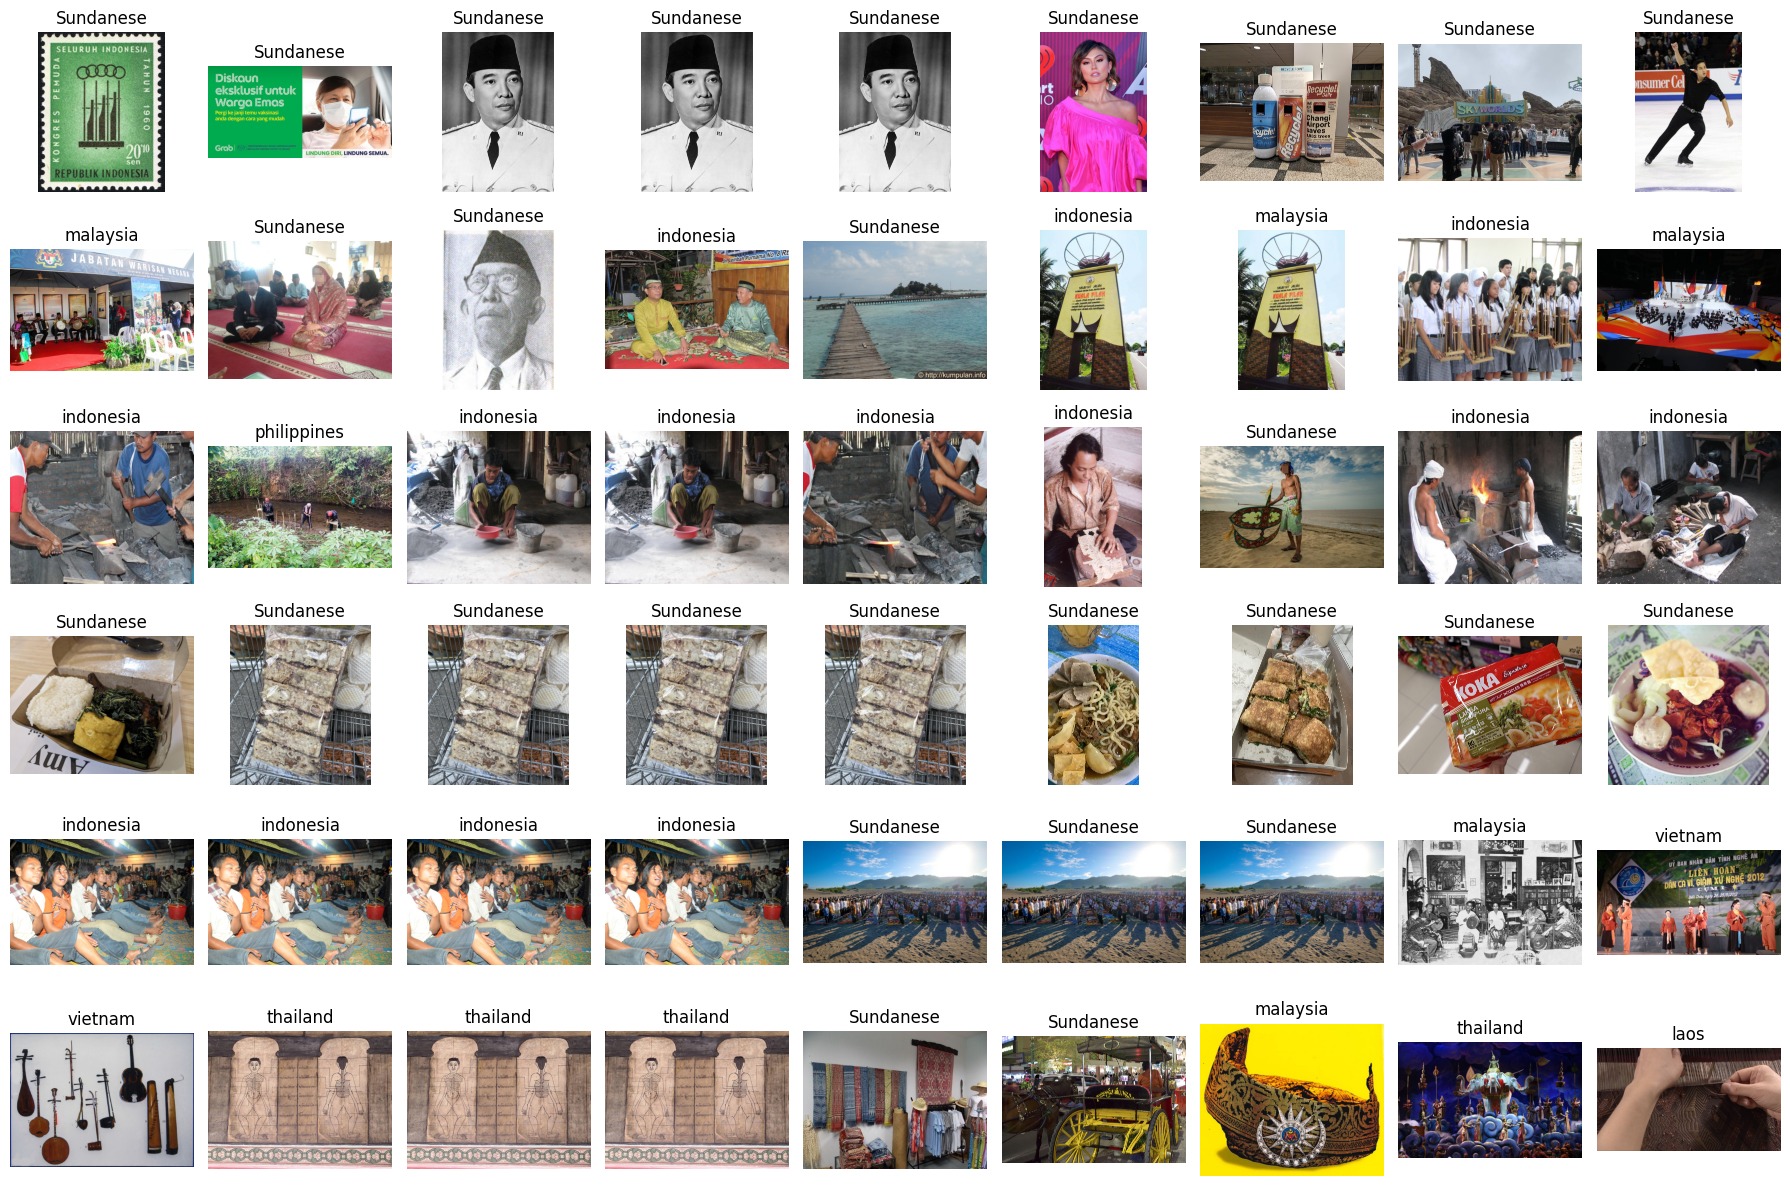

In [44]:
import pandas as pd

topk = 9
fig, axes = plt.subplots(best_k, topk, figsize=(18, 12))
dist2centroid = dist_mat.dot(kmeans.cluster_centers_.T).min(axis=-1)
for cluster_id, df in pd.DataFrame({'cluster': cluster_labels, 'd2c': dist2centroid, 'index': range(len(cluster_labels))}).groupby('cluster'):
    for j, idx in enumerate(df.sort_values('d2c', ascending=True).head(topk * 3)['index'][::3]):
        # Plot the image
        axes[cluster_id, j].imshow(ref_images_filt[idx], cmap='gray')
        axes[cluster_id, j].axis('off')
        
        # Add the caption
        axes[cluster_id, j].set_title(ref_vqa_culture[idx])
        
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Summary
- The best number of cluster k would be around 5-8
- Unsupervised clustering can capture cluster for food quite well
- Nonetheless, for others it is kinda mix up, e.g., sports, arts, etc

### Next Step
> Use the group classification on CVQA for clustering
